# Lumped lake model equations 

The dynamics of storm surges on a lake generally contains contributions from 2 separate processes:
- The wind stress at the surface can push the water in a direction, which creates a slopes that causes a counteracting pressure gradient. For persistend winds, this can
  move towards an equilibrium.
- There can be one or more rivers that feed into the lake and a river of dam that allows excess water to flow out of the lake. This second process generally has 
  longer time-scale, but it does determine the water balance and thus the volume of water in the lake. The water volume at the start of a storm serves as the offset 
  for the storm-surge. Here, we'll assume that the outflow from the lake is controlled by a dam.

## 1d model

The model will be based on a simplification of the linearized 1d shallow-water equations:

$\partial h/\partial t + D \partial u / \partial x = 0$

$\partial u/\partial t + g \partial h / \partial x + \phi/D u= \tau_w /(\rho D)$

where $h$ denotes the water-height above the reference, $u$ the velocity, $D$ the depth below the reference and $t,x$ time and space. Finally, the wind-stress $\tau_w$ acts as an exernal forcing to the water surface.

The domain is $x \in [-L/2,L/2]$. A river with discharge $q_{in} [m^3/s]$ flows into the lake at $x=0$. While a dam a $x=L$ can extract water at a rate $q_{out} [m^3/s]$. This results in the Neumann boundary conditions:

- $u(x=-L/2,t) = \frac{q_{in}(t)}{D W}$ 
- $u(x=L/2,t) = \frac{q_{out}(t)}{D W}$

where $W$ is the width of the inflow and outflow.

## 0d model

We can further simplify the model by lumping the variables $h$ and $u$. Let

- $h \approx h_0 + h_s*\sin(\pi x/L)$
- $u \approx u_c \cos(\pi x/L)$

Let's first consider the case where $q_{in}=0$ and $q_{out}=0$, and assume that $\tau \approx \tau_c \cos(\pi x/L)$. We can substitute this in the 1d model:

Starting with the continuity equation

- $\partial h_0/\partial t + \sin(\pi x/L) ( \partial h_s/\partial t - D \pi/L u_c) = 0$

which is satisfied for all $x$ when:

- $\partial h_0/\partial t  = 0$ and
- $\partial h_s/\partial t - D \pi/L u_c = 0$

Next, consider the momentum equation:

- $\cos(\pi/L) \partial u_c/\partial t + \cos(\pi/L) \pi g/L h_s  + \cos(\pi/L) \phi/D u= \cos(\pi/L) \tau_c /(\rho D)$

which is satisfied for all $x$ when:

- $\partial u_c/\partial t + \pi g/L h_s + \phi/D u= \tau_c /(\rho D)$

When the inflow and outflow are non-zero, we simply assume that this only contributes to the volume:

- $\partial h_0/\partial t  = \frac{q_{in}-q_{out}}{LW}$ 

Collecting the parts, we have the lumped model:

- $\partial h_0/\partial t  = \frac{q_{in}-q_{out}}{LW}$ 
- $\partial h_s/\partial t = D \pi/L u_c $
- $\partial u_c/\partial t = -\pi g/L h_s - \phi/D u + \tau_c /(\rho D)$



In [2]:
# goto folder of this notebook (If you move this notebook then also copy the Project.toml file and run instantiate to install the packages)
cd(@__DIR__)
# load the environment
using Pkg 
Pkg.activate(".")  # activate the environment for this notebook
# load the packages
using OrdinaryDiffEq
using StaticArrays
using Plots
using JLD2


  Activating project at `~/dellete/src/julia_ml_tests.jl.git/model_0d`


In [33]:
# Model equations

# forcing functions
function tau_c(t)  # wind stress [m^2/s^2]
    return 1.0*sin(2*pi/24/3600*t)  # periodic wind stress with period of 24 hours
end

q_in(t) = 100.0  # inflow discharge [m^3/s]
q_out(t) = 50.0  # outflow discharge [m^3/s]


function lake_0d(u, p, t)
	# compute f(x,p,t) for ode dx/dt=f(x,p,t)
    h0, hs, uc = u
    L, W, D, g, phi, rho = p # unpack parameters
    dh0_dt = q_in(t)/(L*W) - q_out(t)/(L*W)  # change in mean water level due to inflow and outflow
    dhs_dt = D*pi*uc/L   # change in surface slope 
    duc_dt = -g*pi*hs/L - phi/D*uc + tau_c(t)/(rho*D) # change in velocity 
    return  @SVector [dh0_dt, dhs_dt, duc_dt] # the @SVector creates a short-lived vector that's faster. It will work without, but a bit slower.
end


lake_0d (generic function with 1 method)

In [48]:
# setting up the problem

# parameters
L=30.0e3   # length of the domain [m]
W=L        # width of the domain [m]
D=4.0      # depth of the lake [m]
g=9.81     # gravity [m/s^2]
phi=1.0e-4 # friction parameter [m/s]
rho=1000.0 # density of water [kg/m^3]
p=(L, W, D, g, phi, rho)       # parameters (not used in this case)

# simulation parameters
t_end=25*24.0*3600.0  # end time [s]

# initial condition
u0 = @SVector [0.0, 0.0, 0.0]  # initial condition: [mean water level, surface slope, velocity]


3-element SVector{3, Float64} with indices SOneTo(3):
 0.0
 0.0
 0.0

In [49]:
prob = ODEProblem(lake_0d, u0, (0.0, t_end),p)
@time sol = solve(prob, Tsit5(),saveat=10.0) # with timing, but ouput only at t=10.0
sol = solve(prob, Tsit5()) # store output, no timing

nothing

  0.018922 seconds (47 allocations: 12.232 MiB, 29.21% gc time)


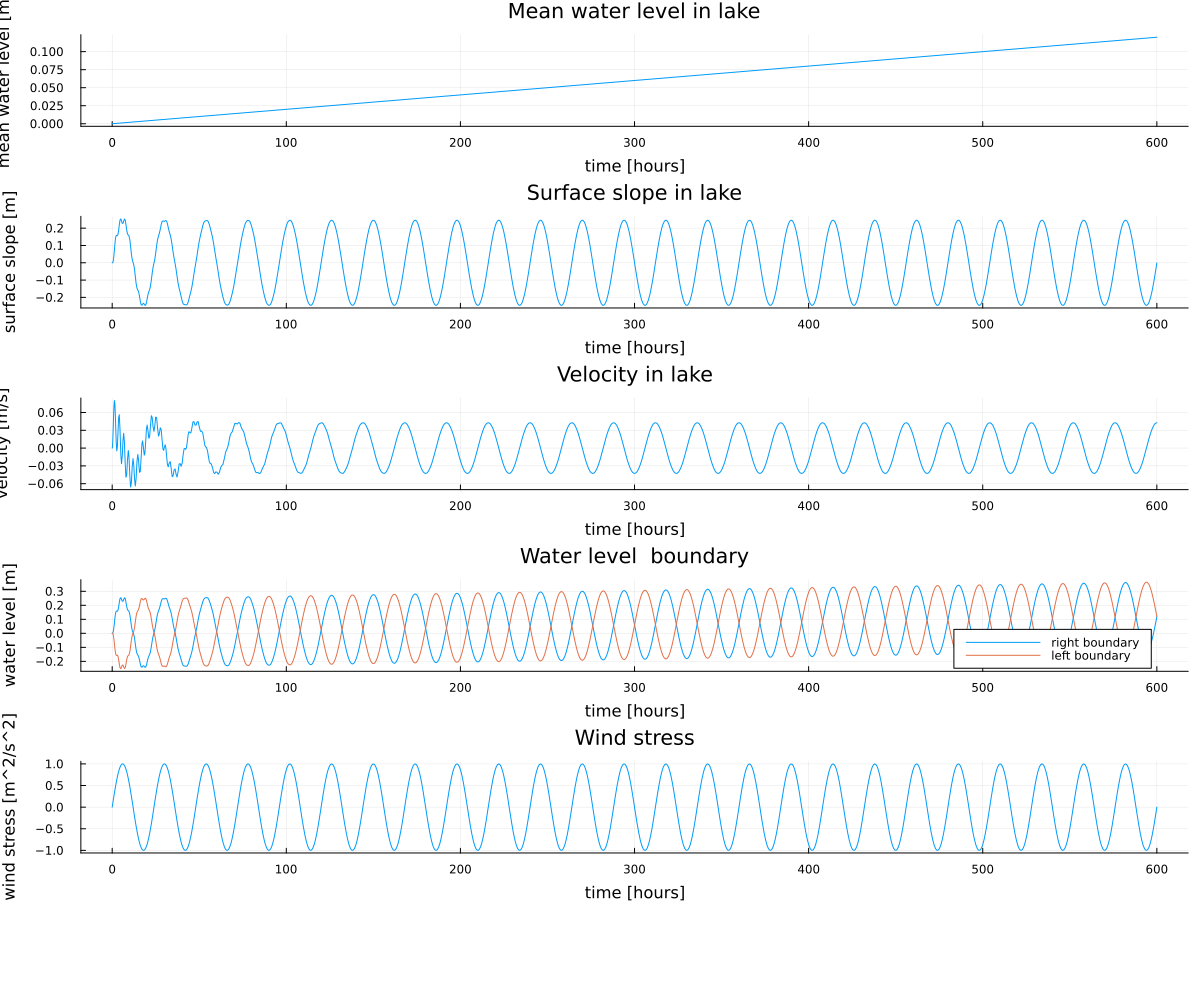

In [57]:
# Plot results
p1=plot(sol.t./3600, getindex.(sol.u,1), xlabel="time [hours]", ylabel="mean water level [m]", legend=false, title="Mean water level in lake")
p2=plot(sol.t./3600, getindex.(sol.u,2), xlabel="time [hours]", ylabel="surface slope [m]", legend=false, title="Surface slope in lake")
p3=plot(sol.t./3600, getindex.(sol.u,3), xlabel="time [hours]", ylabel="velocity [m/s]", legend=false, title="Velocity in lake")
p4=plot(sol.t./3600, getindex.(sol.u,1).+getindex.(sol.u,2), xlabel="time [hours]", ylabel="water level [m]", label="right boundary", title="Water level  boundary")
plot!(p4,sol.t./3600, getindex.(sol.u,1).-getindex.(sol.u,2), xlabel="time [hours]", ylabel="water level [m]", label="left boundary", title="Water level  boundary")
p5=plot(sol.t./3600, tau_c.(sol.t), xlabel="time [hours]", ylabel="wind stress [m^2/s^2]", legend=false, title="Wind stress")

plot(p1,p2,p3,p4,p5, layout=(6,1), size=(1200,1000))

In [ ]:
# # save the solution to a JLD2 file
# cfl_out=1.0 # CFL number for output
# dt_out=cfl_out*f.Δx/u_mean # time step for output, based on CFL condition
# times=collect(0.0:dt_out:t_end) # output times
# solution=[]
# for t in times
#     push!(solution, sol(t))
# end
# # save the solution to a JLD2 file
# save("burgers1d_periodic.jld2", 
#     "solution", solution,
#     "times", times,
#     "params", (ν=ν, Δx=Δx, u_mean=u_mean, u_amplitude=u_amplitude, k=k),
#     "grid", x,
#     "cfl_out", cfl_out,
#     "dt_out", dt_out,
#     "description", "Solution of the 1D Burgers equation with periodic boundary conditions, using a cosine as initial condition.")


In [ ]:
# # load the solution from the JLD2 file for testing
# ff=load("burgers1d_periodic.jld2")

# @show ff["solution"][1][1:20:end] # show some values of the initial velocity field